In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
ratings = pd.read_csv('../ml-latest-small/ratings.csv')
movies = pd.read_csv('../ml-latest-small/movies.csv')

In [3]:
def split(df : pd.DataFrame, ratio=0.7):
    splited = df.sample(frac=1)
    threshold = int(ratio * df.shape[0])
    return (splited[:threshold], splited[threshold:])

In [4]:
def mse(pred, res):
    return np.mean(np.square(pred - res))

In [5]:
def rmse(pred, res):
    return np.sqrt(mse(pred, res))

In [6]:
def euclidian_sim(vec_a, vec_b):
    return np.linalg.norm(vec_a - vec_b)

In [7]:
def cosine_similarity(vec_a, vec_b):
    co_rated = np.intersect1d(np.where(np.isnan(vec_a) == False)[0], 
                              np.where(np.isnan(vec_b) == False)[0])
    den = np.sqrt(np.dot(np.nansum(np.square(vec_a)), np.nansum(np.square(vec_b))))
    return np.sum(vec_a[co_rated] * vec_b[co_rated]) / den

In [8]:
def pearson_similarity(vec_a : np.ndarray, vec_b : np.ndarray):
    user_a_mean : float = np.mean(vec_a[np.where(np.isnan(vec_a) == False)[0]])
    user_b_mean : float = np.mean(vec_b[np.where(np.isnan(vec_b) == False)[0]])
    
    adjusted_vec_a = np.nan_to_num(vec_a - user_a_mean)
    adjusted_vec_b = np.nan_to_num(vec_b - user_b_mean)

    den = np.linalg.norm(adjusted_vec_a) * np.linalg.norm(adjusted_vec_b)
    if den == 0:
        return den
    
    return np.dot(adjusted_vec_a, adjusted_vec_b) / den
    

In [9]:
class KNN:
    def __init__(self, similarity_func, k=3, co_rated_min=5, rating_matrix:np.ndarray=np.array([]), similarity_matrix:np.ndarray=np.array([])) -> None:
        self.similarity_func = similarity_func
        self.k = k
        self.co_rated_min = co_rated_min
        self.rating_matrix: np.ndarray = rating_matrix
        self.similarity_matrix = similarity_matrix

    def calculate_rating_matrix(self, rating_df: pd.DataFrame):
        n_users = int(rating_df.values[:, 0].max())
        n_movies = int(rating_df.values[:, 1].max())
        rating_matrix = np.zeros(shape=(n_users, n_movies))
        rating_matrix.fill(np.nan)
        for tup in rating_df.values[:, :3]:
            rating_matrix[int(tup[0] - 1), int(tup[1] - 1)] = tup[2]
        return rating_matrix
        
    def calculate_similarity_matrix(self, rating_matrix: np.ndarray):
        matrix = np.zeros(shape=(rating_matrix.shape[0], rating_matrix.shape[0]))
        for i in tqdm(range(rating_matrix.shape[0])):
            for j in range(i, rating_matrix.shape[0]):
                matrix[i, j] = matrix[j, i] = self.similarity_func(rating_matrix[i], rating_matrix[j])
        return matrix
    
    def similarity(self, user_a, user_b):
        try:
            sim = self.similarity_matrix[user_a, user_b]
            return sim if sim != 0 else self.similarity_func(self.rating_matrix[user_a], self.rating_matrix[user_b])
        except:
            return self.similarity_func(self.rating_matrix[user_a], self.rating_matrix[user_b])

    def fit(self, rating_df: pd.DataFrame):
        rating_matrix = self.calculate_rating_matrix(rating_df)
        similarity_matrix = self.calculate_similarity_matrix(rating_matrix)
        return KNN(self.similarity_func, self.k, self.co_rated_min, rating_matrix, similarity_matrix)
    
    def predict_one(self, user_id, item_id):
        neighbours = []
        for user in range(self.rating_matrix.shape[0]):
            if user_id != user:
                co_rated = np.intersect1d(np.where(np.isnan(self.rating_matrix[user_id]) == False)[0], 
                                            np.where(np.isnan(self.rating_matrix[user]) == False)[0])
                if len(co_rated) >= self.co_rated_min:
                    neighbours.append((int(user), self.similarity_func(self.rating_matrix[user], self.rating_matrix[user_id])))
        users = np.array(neighbours)[:, 0]
        co_rated_with_item = [neighbours[k] for k, i in enumerate(users) if not np.isnan(self.rating_matrix[int(i), int(item_id)])]
        co_rated_with_item = np.array(sorted(co_rated_with_item, key=lambda x: x[1], reverse=True)[:self.k])
        if len(co_rated_with_item) > 0:
                rating_user = [self.rating_matrix[int(i)][int(item_id)] for i in co_rated_with_item[:, 0]]
                return np.sum(rating_user * co_rated_with_item[:, 1]) / np.sum(co_rated_with_item[:, 1])
        else:
            return np.nanmean(self.rating_matrix)

    def predict_one_user(self, user_id, items_id):
        return_ratings = np.array([])
        neighbours = []
        for user in range(self.rating_matrix.shape[0]):
            if user_id != user:
                co_rated = np.intersect1d(np.where(np.isnan(self.rating_matrix[user_id]) == False)[0], 
                                            np.where(np.isnan(self.rating_matrix[user]) == False)[0])
                if len(co_rated) >= self.co_rated_min:
                    neighbours.append((int(user), self.similarity_func(self.rating_matrix[user], self.rating_matrix[user_id])))
        users = np.array(neighbours)[:, 0]
        for item in items_id:
            co_rated_with_item = [neighbours[k] for k, i in enumerate(users) if not np.isnan(self.rating_matrix[int(i), int(item)])]
            co_rated_with_item = np.array(sorted(co_rated_with_item, key=lambda x: x[1], reverse=True)[:self.k])
            if len(co_rated_with_item) > 0:
                rating_user = [self.rating_matrix[int(i)][int(item)] for i in co_rated_with_item[:, 0]]
                new_rating = np.sum(rating_user * co_rated_with_item[:, 1]) / np.sum(co_rated_with_item[:, 1])
                return_ratings = np.append(return_ratings, new_rating)
            else:
                return_ratings = np.append(return_ratings, np.nanmean(self.rating_matrix))
        return return_ratings
    

    def predict(self, rating_df: pd.DataFrame):
        rated_values = []
        for user_id, item_id,  in tqdm(rating_df.values[:, :2]):
            rated_values.append(self.predict_one(int(user_id) - 1, int(item_id) - 1))
        return rated_values


In [10]:
train, test = split(ratings, 0.98)
test.shape

(2017, 4)

In [12]:
rmse_cos = []
mse_cos = []

rmse_pearson = []
mse_pearson = []

for k in range(3, 10, 2):
    knn_cos = KNN(cosine_similarity, k=k).fit(train)
    predicted_cos = knn_cos.predict(test)
    rmse_cos.append(rmse(predicted_cos, test.values[:, 2]))
    mse_cos.append(mse(predicted_cos, test.values[:, 2]))

    knn_pearson = KNN(pearson_similarity, k=k).fit(train)
    predicted_pearson = knn_pearson.predict(test)
    rmse_pearson.append(rmse(predicted_pearson, test.values[:, 2]))
    mse_pearson.append(mse(predicted_pearson, test.values[:, 2]))

100%|██████████| 2017/2017 [1:03:06<00:00,  1.88s/it]


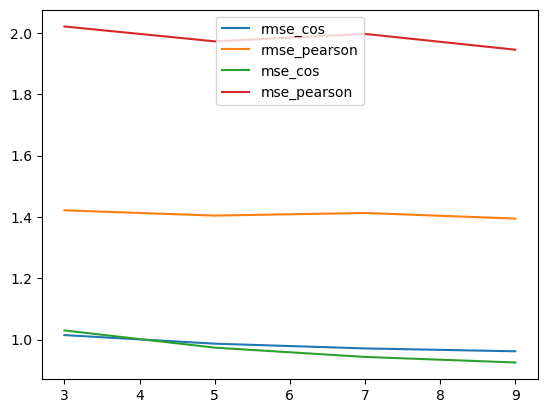

In [16]:
plt.plot(range(3, 10, 2), rmse_cos, label='rmse_cos')
plt.plot(range(3, 10, 2), rmse_pearson, label='rmse_pearson')
plt.plot(range(3, 10, 2), mse_cos, label='mse_cos')
plt.plot(range(3, 10, 2), mse_pearson, label='mse_pearson')
plt.legend(loc='best')
plt.show()